In [1]:
# torch and visulization
from tqdm             import tqdm
import torch.optim    as optim
from torch.optim      import lr_scheduler
from torchvision      import transforms
from torch.utils.data import DataLoader
from model.parse_args_train import  parse_args

# metric, loss .etc
from model.utils import *
from model.metric import *
from model.loss import *
from model.load_param_data import  load_dataset, load_param

# model
from model.model_DNANet import  Res_CBAM_block
from model.model_DNANet import  DNANet
from model.model_DeepNFA import DeepNFA

Text(0, 0.5, 'SIGMα')

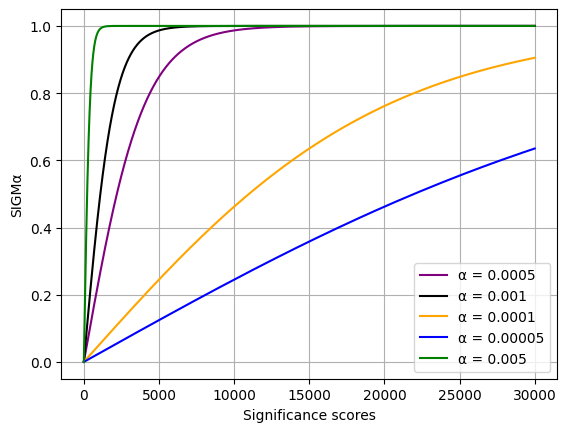

In [2]:
# SIGMAα activation function (Ntest=1)
from model.model_DeepNFA import SIGMalpha

sigma1 = SIGMalpha(0.0005)
sigma2 = SIGMalpha(0.001)
sigma3 = SIGMalpha(0.0001)
sigma4 = SIGMalpha(0.00005)
sigma5 = SIGMalpha(0.005)

x = torch.arange(0,30000).unsqueeze(1).unsqueeze(1)

y1 = sigma1(x)
y2 = sigma2(x)
y3 = sigma3(x)
y4 = sigma4(x)
y5 = sigma5(x)

plt.plot(x.squeeze(), y1.squeeze(), c='purple', label='α = 0.0005')
plt.plot(x.squeeze(), y2.squeeze(), c='black', label='α = 0.001')
plt.plot(x.squeeze(), y3.squeeze(), c='orange', label='α = 0.0001')
plt.plot(x.squeeze(), y4.squeeze(), c='blue', label='α = 0.00005')
plt.plot(x.squeeze(), y5.squeeze(), c='green', label='α = 0.005')
plt.legend()
plt.grid()
plt.xlabel('Significance scores')
plt.ylabel('SIGMα')

Text(0, 0.5, 'NFA')

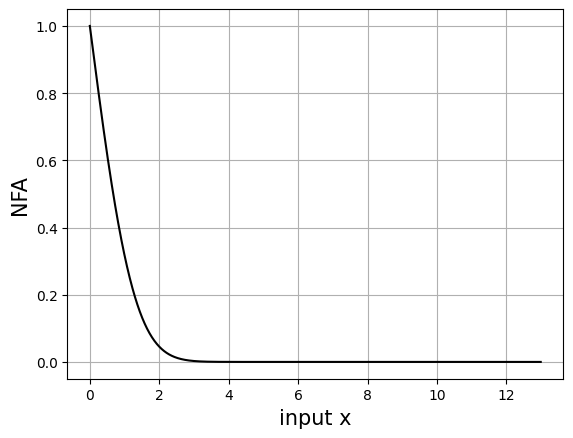

In [3]:
def gamma_approx(a, x):
    return torch.pow(x, a-1)*torch.exp(-x)*(1+(a-1)/x+(a-1)*(a-2)/torch.pow(x,2))

def NFA2(x, n_pixels, n_channels):
    return n_pixels*torch.special.gammaincc(n_channels/2,(torch.pow(x,2).sum(1))/2)

def NFA(x, n_pixels, n_channels):
    return (n_pixels/torch.exp(torch.special.gammaln(n_channels/2)))*gamma_approx(n_channels/2,(torch.pow(x,2).sum(1))/2)

x = torch.arange(0,13, step=0.01).unsqueeze(1).unsqueeze(1).unsqueeze(1)
n_pixels = torch.tensor(1)
n_channels = torch.tensor(1)
nfa = NFA2(x, n_pixels, n_channels)

plt.plot(x.squeeze(), nfa.squeeze(), c='black')
plt.grid()
plt.xlabel('input x', fontsize=15)
plt.ylabel('NFA', fontsize=15)

Text(0, 0.5, 'Significance')

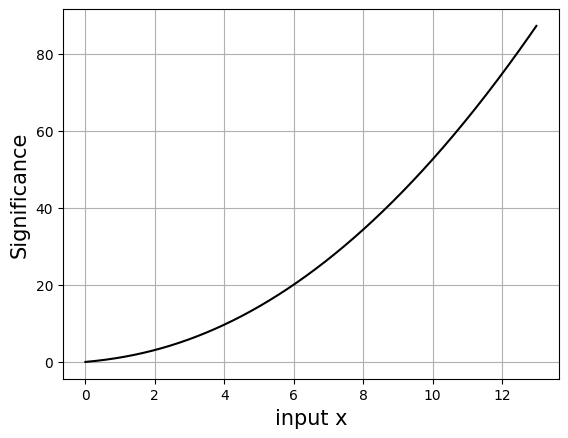

In [4]:
sign = -torch.log(nfa)
plt.plot(x.squeeze(), sign.squeeze(), c='black')
plt.grid()
plt.xlabel('input x', fontsize=15)
plt.ylabel('Significance', fontsize=15)

Text(0.5, 1.0, 'Significance score for X_i with unit variance and N_test=1')

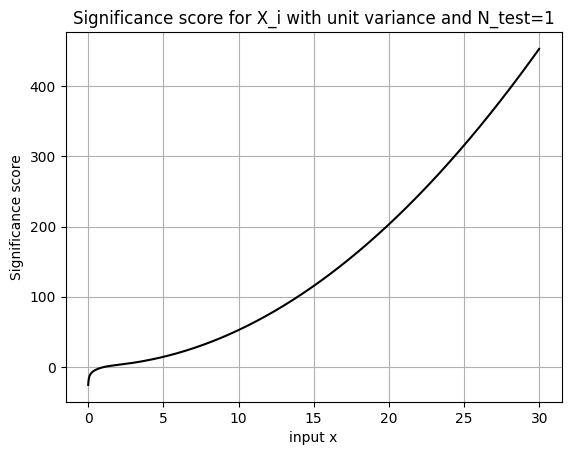

In [5]:
# Significance
def ln_gamma_approx(a, x):
    return (a-1)*torch.log(x+1e-8) - x + torch.log(1 + (a-1)/(x+1e-8) + (a-1)*(a-2)/(torch.pow(x,2)+1e-8))

def significance_score(x, n_pixels, n_channels):
    return torch.lgamma(n_channels/2) -torch.log(n_pixels) - ln_gamma_approx(n_channels/2,(torch.pow(x,2).sum(1))/2)

class Significance(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        n_pixels = torch.tensor(x.size(-1)*x.size(-2))
        n_channels = torch.tensor(x.size(1))
        return significance_score(x, n_pixels, n_channels)
    
signif = Significance()

x = torch.arange(0,30, step=0.01).unsqueeze(1).unsqueeze(1).unsqueeze(1)
y = signif(x)

plt.plot(x.squeeze(), y.squeeze(), c='black')
plt.grid()
plt.xlabel('input x')
plt.ylabel('Significance score')
plt.title('Significance score for X_i with unit variance and N_test=1')

Text(0.5, 1.0, 'Significance score for X_i with unit variance and N_test=1')

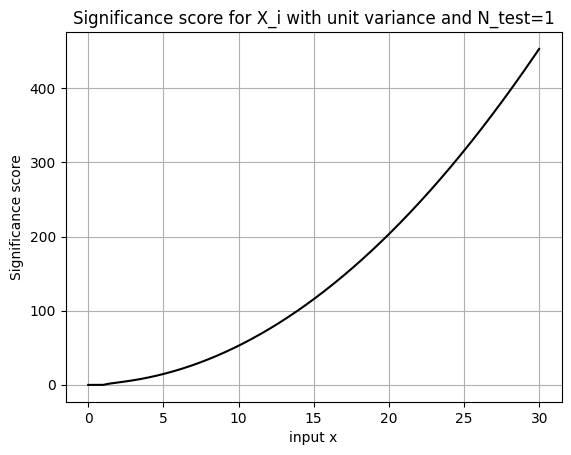

In [6]:
# Significance
def ln_gamma_approx(a, x):
    return (a-1)*torch.log(x+1e-8) - x + torch.log(1 + (a-1)/(x+1e-8) + (a-1)*(a-2)/(torch.pow(x,2)+1e-8))

def significance_score(x, n_pixels, n_channels):
    return torch.lgamma(n_channels/2) -torch.log(n_pixels) - ln_gamma_approx(n_channels/2,(torch.clamp(torch.pow(x,2).sum(1), min=n_channels))/2)

class Significance(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        n_pixels = torch.tensor(x.size(-1)*x.size(-2))
        n_channels = torch.tensor(x.size(1))
        return significance_score(x, n_pixels, n_channels)
    
signif = Significance()

x = torch.arange(0,30, step=0.01).unsqueeze(1).unsqueeze(1).unsqueeze(1)
y = signif(x)

plt.plot(x.squeeze(), y.squeeze(), c='black')
plt.grid()
plt.xlabel('input x')
plt.ylabel('Significance score')
plt.title('Significance score for X_i with unit variance and N_test=1')

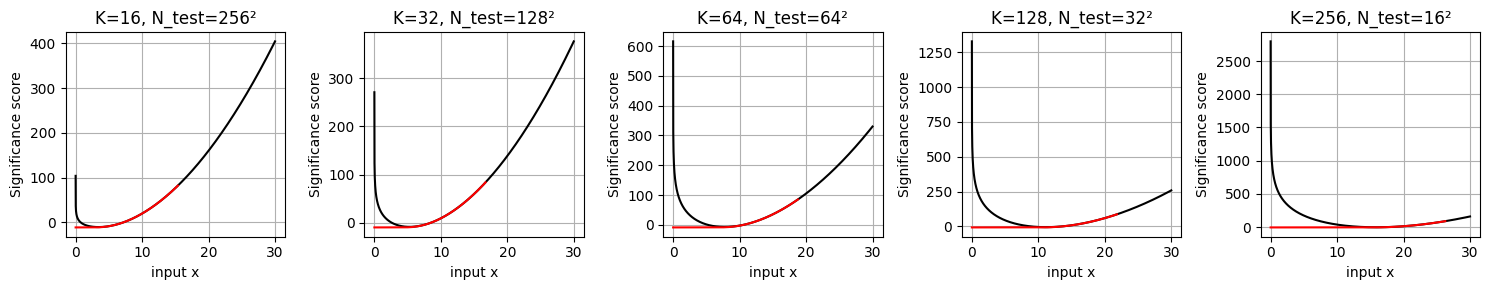

In [176]:
def ln_gamma_approx(a, x):
    return (a-1)*torch.log(x+1e-8) - x + torch.log(1 + (a-1)/(x+1e-8) + (a-1)*(a-2)/(torch.pow(x,2)+1e-8))

def significance_score(x, n_pixels, n_channels):
    return torch.lgamma(n_channels/2) -torch.log(n_pixels) - ln_gamma_approx(n_channels/2,(torch.pow(x,2).sum(1))/2)


x = torch.arange(0,30, step=0.01).unsqueeze(1)
y1 = significance_score(x, torch.tensor(256*256), torch.tensor(16))
y2 = significance_score(x, torch.tensor(128*128), torch.tensor(32))
y3 = significance_score(x, torch.tensor(64*64), torch.tensor(64))
y4 = significance_score(x, torch.tensor(32*32), torch.tensor(128))
y5 = significance_score(x, torch.tensor(16*16), torch.tensor(256))

y1_exact = -torch.log(NFA2(x, torch.tensor(256*256), torch.tensor(16)))
y2_exact = -torch.log(NFA2(x, torch.tensor(128*128), torch.tensor(32)))
y3_exact = -torch.log(NFA2(x, torch.tensor(64*64), torch.tensor(64)))
y4_exact = -torch.log(NFA2(x, torch.tensor(32*32), torch.tensor(128)))
y5_exact = -torch.log(NFA2(x, torch.tensor(16*16), torch.tensor(256)))


plt.figure(figsize=(15,3))
plt.subplot(151)
plt.grid()
plt.ylabel('Significance score')
plt.xlabel('input x')
plt.title('K=16, N_test=256²')
plt.plot(x.squeeze(), y1, c='black')
plt.plot(x.squeeze(), y1_exact, c='red')
plt.subplot(152)
plt.grid()
plt.ylabel('Significance score')
plt.xlabel('input x')
plt.title('K=32, N_test=128²')
plt.plot(x.squeeze(), y2, c='black')
plt.plot(x.squeeze(), y2_exact, c='red')
plt.subplot(153)
plt.grid()
plt.ylabel('Significance score')
plt.xlabel('input x')
plt.title('K=64, N_test=64²')
plt.plot(x.squeeze(), y3, c='black')
plt.plot(x.squeeze(), y3_exact, c='red')
plt.subplot(154)
plt.grid()
plt.ylabel('Significance score')
plt.xlabel('input x')
plt.title('K=128, N_test=32²')
plt.plot(x.squeeze(), y4, c='black')
plt.plot(x.squeeze(), y4_exact, c='red')
plt.subplot(155)
plt.grid()
plt.ylabel('Significance score')
plt.xlabel('input x')
plt.title('K=256, N_test=16²')
plt.plot(x.squeeze(), y5, c='black')
plt.plot(x.squeeze(), y5_exact, c='red')

plt.tight_layout()

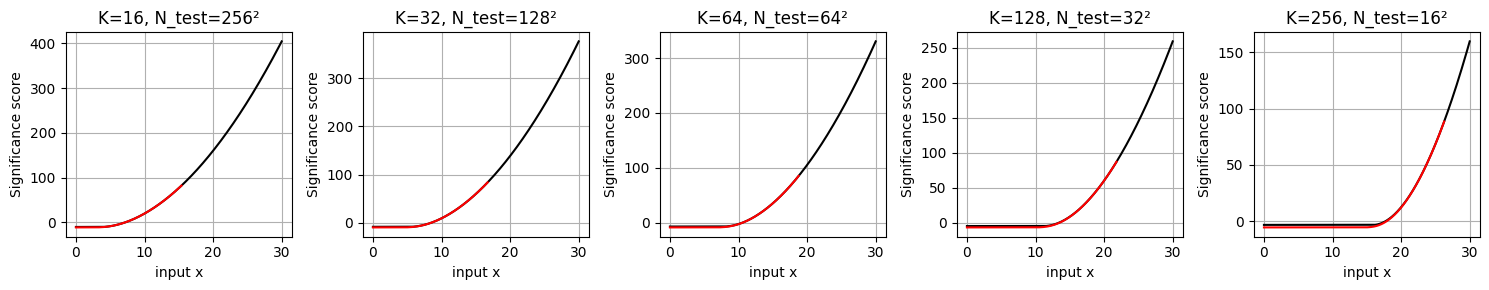

In [177]:
def ln_gamma_approx(a, x):
    return (a-1)*torch.log(x+1e-8) - x + torch.log(1 + (a-1)/(x+1e-8) + (a-1)*(a-2)/(torch.pow(x,2)+1e-8))

def significance_score(x, n_pixels, n_channels):
    return torch.lgamma(n_channels/2) -torch.log(n_pixels) - ln_gamma_approx(n_channels/2,(torch.clamp(torch.pow(x,2).sum(1), min=n_channels))/2)


x = torch.arange(0,30, step=0.001).unsqueeze(1)
y1 = significance_score(x, torch.tensor(256*256), torch.tensor(16))
y2 = significance_score(x, torch.tensor(128*128), torch.tensor(32))
y3 = significance_score(x, torch.tensor(64*64), torch.tensor(64))
y4 = significance_score(x, torch.tensor(32*32), torch.tensor(128))
y5 = significance_score(x, torch.tensor(16*16), torch.tensor(256))

y1_exact = -torch.log(NFA2(x, torch.tensor(256*256), torch.tensor(16)))
y2_exact = -torch.log(NFA2(x, torch.tensor(128*128), torch.tensor(32)))
y3_exact = -torch.log(NFA2(x, torch.tensor(64*64), torch.tensor(64)))
y4_exact = -torch.log(NFA2(x, torch.tensor(32*32), torch.tensor(128)))
y5_exact = -torch.log(NFA2(x, torch.tensor(16*16), torch.tensor(256)))


plt.figure(figsize=(15,3))
plt.subplot(151)
plt.grid()
plt.ylabel('Significance score')
plt.xlabel('input x')
plt.title('K=16, N_test=256²')
plt.plot(x.squeeze(), y1, c='black')
plt.plot(x.squeeze(), y1_exact, c='red')
plt.subplot(152)
plt.grid()
plt.ylabel('Significance score')
plt.xlabel('input x')
plt.title('K=32, N_test=128²')
plt.plot(x.squeeze(), y2, c='black')
plt.plot(x.squeeze(), y2_exact, c='red')
plt.subplot(153)
plt.grid()
plt.ylabel('Significance score')
plt.xlabel('input x')
plt.title('K=64, N_test=64²')
plt.plot(x.squeeze(), y3, c='black')
plt.plot(x.squeeze(), y3_exact, c='red')
plt.subplot(154)
plt.grid()
plt.ylabel('Significance score')
plt.xlabel('input x')
plt.title('K=128, N_test=32²')
plt.plot(x.squeeze(), y4, c='black')
plt.plot(x.squeeze(), y4_exact, c='red')
plt.subplot(155)
plt.grid()
plt.ylabel('Significance score')
plt.xlabel('input x')
plt.title('K=256, N_test=16²')
plt.plot(x.squeeze(), y5, c='black')
plt.plot(x.squeeze(), y5_exact, c='red')

plt.tight_layout()

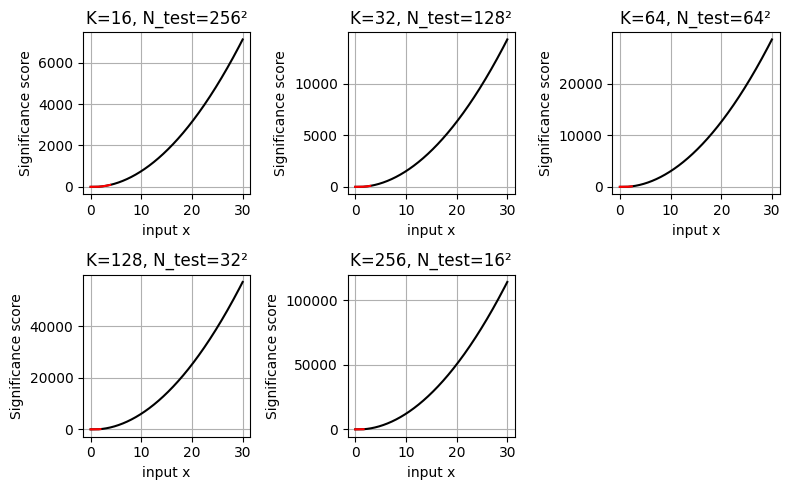

In [9]:
def ln_gamma_approx(a, x):
    return (a-1)*torch.log(x+1e-8) - x + torch.log(1 + (a-1)/(x+1e-8) + (a-1)*(a-2)/(torch.pow(x,2)+1e-8))

def significance_score(x, n_pixels, n_channels):
    return torch.lgamma(n_channels/2) -torch.log(n_pixels) - ln_gamma_approx(n_channels/2,(torch.clamp(torch.pow(x,2).sum(1), min=n_channels))/2)

x = torch.arange(0,30, step=0.001)
x1 = torch.arange(0,30, step=0.001).unsqueeze(1).repeat(1,16)
y1 = significance_score(x1, torch.tensor(256*256), torch.tensor(16))
y1_exact = -torch.log(NFA2(x1, torch.tensor(256*256), torch.tensor(16)))
x2 = torch.arange(0,30, step=0.001).unsqueeze(1).repeat(1,32)
y2 = significance_score(x2, torch.tensor(128*128), torch.tensor(32))
y2_exact = -torch.log(NFA2(x2, torch.tensor(128*128), torch.tensor(32)))
x3 = torch.arange(0,30, step=0.001).unsqueeze(1).repeat(1,64)
y3 = significance_score(x3, torch.tensor(64*64), torch.tensor(64))
y3_exact = -torch.log(NFA2(x3, torch.tensor(64*64), torch.tensor(64)))
x4 = torch.arange(0,30, step=0.001).unsqueeze(1).repeat(1,128)
y4 = significance_score(x4, torch.tensor(32*32), torch.tensor(128))
y4_exact = -torch.log(NFA2(x4, torch.tensor(32*32), torch.tensor(128)))
x5 = torch.arange(0,30, step=0.001).unsqueeze(1).repeat(1,256)
y5 = significance_score(x5, torch.tensor(16*16), torch.tensor(256))
y5_exact = -torch.log(NFA2(x5, torch.tensor(16*16), torch.tensor(256)))


plt.figure(figsize=(8,5))
plt.subplot(231)
plt.grid()
plt.ylabel('Significance score')
plt.xlabel('input x')
plt.title('K=16, N_test=256²')
plt.plot(x, y1, c='black')
plt.plot(x, y1_exact, c='red')
plt.subplot(232)
plt.grid()
plt.ylabel('Significance score')
plt.xlabel('input x')
plt.title('K=32, N_test=128²')
plt.plot(x, y2, c='black')
plt.plot(x, y2_exact, c='red')
plt.subplot(233)
plt.grid()
plt.ylabel('Significance score')
plt.xlabel('input x')
plt.title('K=64, N_test=64²')
plt.plot(x, y3, c='black')
plt.plot(x, y3_exact, c='red')
plt.subplot(234)
plt.grid()
plt.ylabel('Significance score')
plt.xlabel('input x')
plt.title('K=128, N_test=32²')
plt.plot(x, y4, c='black')
plt.plot(x, y4_exact, c='red')
plt.subplot(235)
plt.grid()
plt.ylabel('Significance score')
plt.xlabel('input x')
plt.title('K=256, N_test=16²')
plt.plot(x, y5, c='black')
plt.plot(x, y5_exact, c='red')

plt.tight_layout()

In [20]:
class ECABlock(nn.Module):
    def __init__(self, k_size=3):
        super(ECABlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)
        print(y.shape)
        print(y.squeeze(-1).transpose(-1, -2).shape)
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)
        print(y.shape)
        y = self.sigmoid(y)
        print(y.expand_as(x).shape)
        return x * y.expand_as(x), y

In [22]:
eca_block = ECABlock()

x = torch.randn((32, 5, 256, 256))

x, y = eca_block(x)
y[0]

torch.Size([32, 5, 1, 1])
torch.Size([32, 1, 5])
torch.Size([32, 5, 1, 1])
torch.Size([32, 5, 256, 256])


tensor([[[0.5000]],

        [[0.4995]],

        [[0.4993]],

        [[0.5002]],

        [[0.5008]]], grad_fn=<SelectBackward0>)

In [2]:
model = DeepNFA(3, Res_CBAM_block, [2, 2, 2, 2], [16, 32, 64, 128, 256], 0.0005).cuda()
model = model.apply(weights_init_xavier)

/media/cedric/Stockage1/Documents/Cours/MVA/Semestre2/Théorie de la détection et ses applications industrielles/report/Deep-NFA/model/utils.py:175: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight.data)


In [15]:
x = torch.randn((8, 3, 256, 256)).cuda()
significance, sign_scores_weigthed, sign_scores = model(x, visualization=True)

new block tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
new block tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
new block tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
new block tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
new block tensor(0., device='cuda:0', grad_fn=<MinBackward1>)
tensor(0., device='cuda:0', grad_fn=<MinBackward1>)


In [16]:
significance = significance.detach().cpu().numpy()

In [17]:
np.isnan(significance).sum()

0

In [23]:
test_sign_scores = sign_scores[0][None,:,:,:]
test_sign_scores.shape

(1, 5, 256, 256)

In [24]:
test_sign_scores.max()

40.402664

In [31]:
test_sign_scores[0,2,128:132, 140:145] = 1000

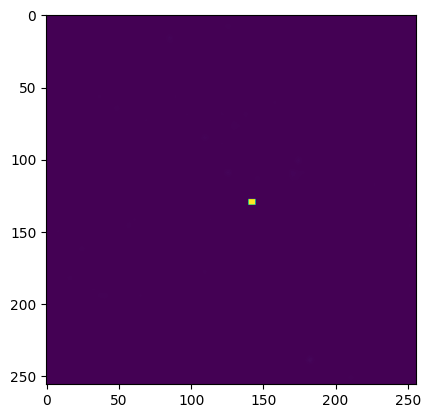

In [34]:
plt.imshow(test_sign_scores[0,2])

In [41]:
union_scores = test_sign_scores.max(axis=1)
union_scores.shape

(1, 256, 256)

In [42]:
union_scores.max()

1000.0

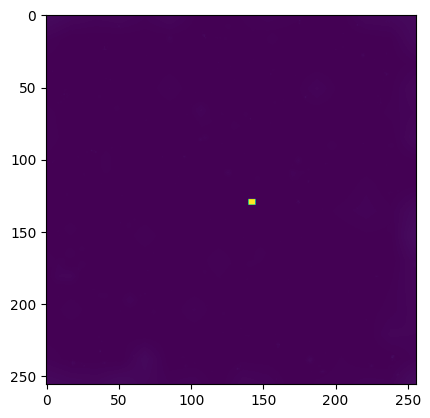

In [43]:
plt.imshow(union_scores[0])

In [19]:
significance.min()

0.0027725697

# Test models

In [2]:
train_img_ids, val_img_ids, test_txt = load_dataset('dataset/', 'NUAA-SIRST', '60_40')
input_transform = transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize([.485, .456, .406], [.229, .224, .225])])
testset         = TestSetLoader('dataset/NUAA-SIRST',img_id=val_img_ids,base_size=256, crop_size=256, transform=input_transform,suffix='.png')
test_data  = DataLoader(dataset=testset,  batch_size=8, num_workers=4,drop_last=False)

#### DNANet

In [3]:
model_dna = DNANet(num_classes=1,input_channels=3, block=Res_CBAM_block, num_blocks=[2, 2, 2, 2], 
               nb_filter=[16, 32, 64, 128, 256], deep_supervision=True)
model_dna           = model_dna.cuda()
checkpoint             = torch.load('result/' + 'pretrained/pretrain_DNANet_model.tar')
model_dna.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [4]:
i_stop = 5
i = 0
for (data, labels) in test_data:
    if i >= i_stop:
        break
    i += 1

model_dna.eval()
with torch.no_grad():
    data = data.cuda()
    preds_dna = model_dna(data)
    pred_dna = preds_dna[-1]
    #pred_dna = nn.functional.sigmoid(pred_dna)
pred_dna = pred_dna.detach().cpu().numpy()

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Create the inverse normalization transform
inverse_normalize = transforms.Normalize(
    mean=(-mean / std),
    std=(1 / std)
)

inputs = inverse_normalize(data).detach().cpu().numpy().transpose(0,2,3,1)

/home/cedric/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


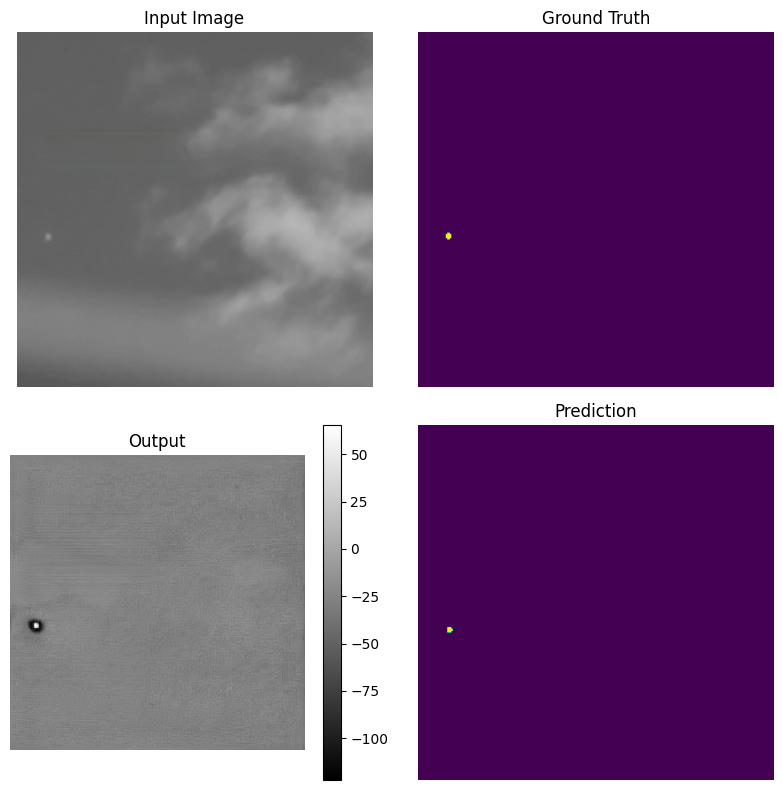

In [24]:
k_batch = 6
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.title('Input Image')
plt.imshow(inputs[k_batch])
plt.axis('off')
plt.subplot(222)
plt.title('Ground Truth')
plt.imshow(labels[k_batch,0])
plt.axis('off')
plt.subplot(223)
plt.title('Output')
plt.imshow(pred_dna[k_batch,0], cmap="gray")
plt.colorbar()
plt.axis('off')
plt.subplot(224)
plt.title('Prediction')
plt.imshow(np.array((pred_dna > 0.5)[k_batch,0]))
plt.axis('off')
plt.tight_layout()

In [ ]:
# false alarm: 5,2 / 5,3 / 7,7 / 19,4
# Missed pred: 5,1 / 21,0
# Interesting: 5,4 / 7,5 / 20,3 / 21,1 / 19,6 / 0,3

#### Deep-NFA

In [6]:
model = DeepNFA(input_channels=3, block=Res_CBAM_block, num_blocks=[2, 2, 2, 2], 
               nb_filter=[16, 32, 64, 128, 256], alpha=0.0005)
model           = model.cuda()
checkpoint             = torch.load('result/' + 'NUAA-SIRST_DeepNFA_27_03_2024_00_31_26_wDS/mIoU__DeepNFA_NUAA-SIRST_epoch.pth.tar')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [21]:
i_stop = 5
i = 0
for (data, labels) in test_data:
    if i >= i_stop:
        break
    i += 1


model.eval()
with torch.no_grad():
    data = data.cuda()
    pred, s_out = model(data)
pred = pred.detach().cpu().numpy()

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Create the inverse normalization transform
inverse_normalize = transforms.Normalize(
    mean=(-mean / std),
    std=(1 / std)
)

inputs = inverse_normalize(data).detach().cpu().numpy().transpose(0,2,3,1)

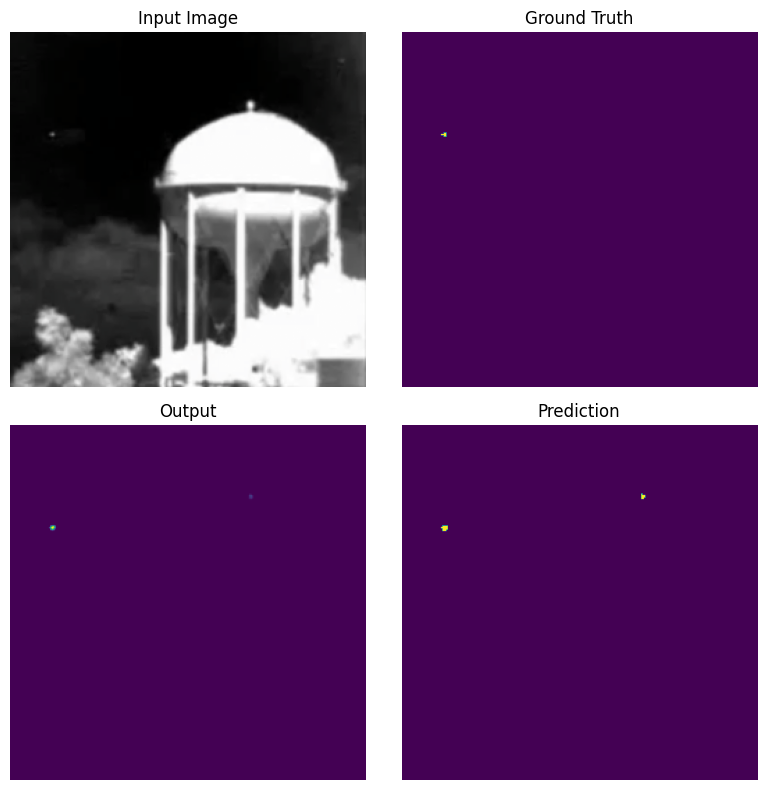

In [22]:
k_batch = 4
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.title('Input Image')
plt.imshow(inputs[k_batch])
plt.axis('off')
plt.subplot(222)
plt.title('Ground Truth')
plt.imshow(labels[k_batch,0])
plt.axis('off')
plt.subplot(223)
plt.title('Output')
plt.imshow(s_out[k_batch,0])
plt.axis('off')
plt.subplot(224)
plt.title('Prediction')
plt.imshow(np.array((pred > 0.1)[k_batch,0]))
plt.axis('off')
plt.tight_layout()

### NFA Fusion

In [43]:
i_stop = 5
i = 0
for (data, labels) in test_data:
    if i >= i_stop:
        break
    i += 1

model.eval()
with torch.no_grad():
    data = data.cuda()
    pred, sign_scores_weighted, sign_scores, weights, features = model(data, visualization=True)
pred = pred.detach().cpu().numpy()

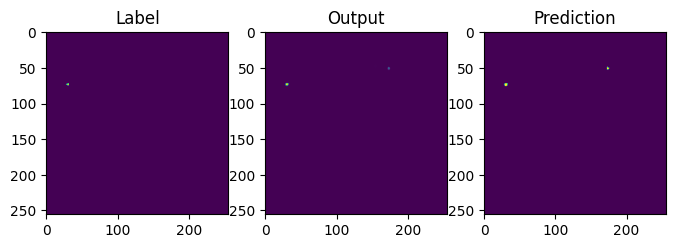

In [44]:
k_batch = 4
plt.figure(figsize=(8,8))
plt.subplot(131)
plt.title('Label')
plt.imshow(labels[k_batch,0])
plt.subplot(132)
plt.title('Output')
plt.imshow(pred[k_batch,0])
plt.subplot(133)
plt.title('Prediction')
plt.imshow(np.array((pred > 0.1)[k_batch,0]))

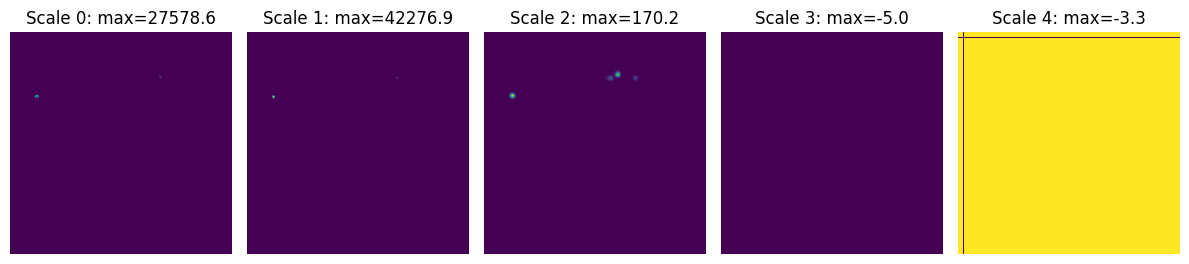

In [45]:
# Significance scores at different scales
plt.figure(figsize=(12,8))
for k in range(sign_scores.shape[1]):
    plt.subplot(1,5,k+1)
    plt.title(f'Scale {k}: max={sign_scores[k_batch,k].max():.1f}')
    plt.imshow(sign_scores[k_batch,k])
    plt.axis('off')

plt.tight_layout()

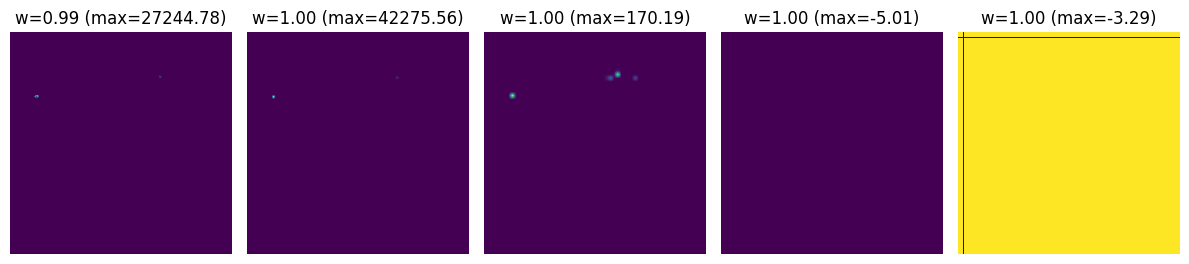

In [46]:
# Weighted significance scores by ECA
plt.figure(figsize=(12,8))
for k in range(sign_scores_weighted.shape[1]):
    plt.subplot(1,5,k+1)
    plt.title(f'w={weights[k_batch,k,0,0]:.2f} (max={sign_scores_weighted[k_batch,k].max():.2f})')
    plt.imshow(sign_scores_weighted[k_batch,k])
    plt.axis('off')

plt.tight_layout()

(-0.5, 255.5, 255.5, -0.5)

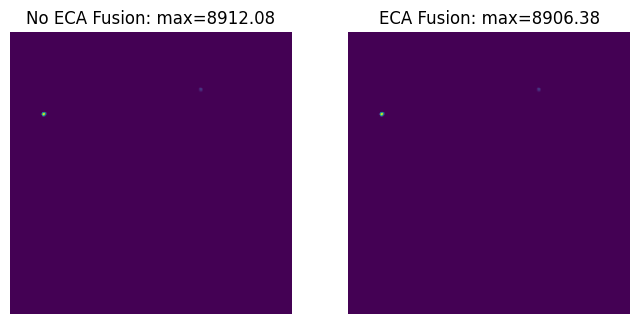

In [47]:
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
significance_fused = sign_scores.mean(axis=1)#[0]
plt.title(f'No ECA Fusion: max={significance_fused[k_batch].max():.2f}')
plt.imshow(significance_fused[k_batch])
plt.axis('off')
plt.subplot(1,2,2)
significance_fused = sign_scores_weighted.mean(axis=1)#[0]
plt.title(f'ECA Fusion: max={significance_fused[k_batch].max():.2f}')
plt.imshow(significance_fused[k_batch])
plt.axis('off')

In [48]:
def ln_gamma_approx(a, x):
    return (a-1)*torch.log(x+1e-8) - x + torch.log(1 + (a-1)/(x+1e-8) + (a-1)*(a-2)/(torch.pow(x,2)+1e-8))

def significance_score(x, n_pixels, n_channels):
    return torch.lgamma(n_channels/2) -torch.log(n_pixels) - ln_gamma_approx(n_channels/2,(torch.clamp(torch.pow(x,2).sum(1), min=n_channels.item()))/2)

x = torch.tensor(features[0])
n_pixels = torch.tensor(x.size(-1)*x.size(-2))
n_channels = torch.tensor(x.size(1))

y = significance_score(x, n_pixels, n_channels)

In [49]:
i_stop = 5
i = 0
for (data, labels) in test_data:
    if i >= i_stop:
        break
    i += 1

model_dna.eval()
with torch.no_grad():
    data = data.cuda()
    preds_dna, features_dna = model_dna(data, visualization=True)
    pred_dna = preds_dna[-1]
pred_dna = pred_dna.detach().cpu().numpy()

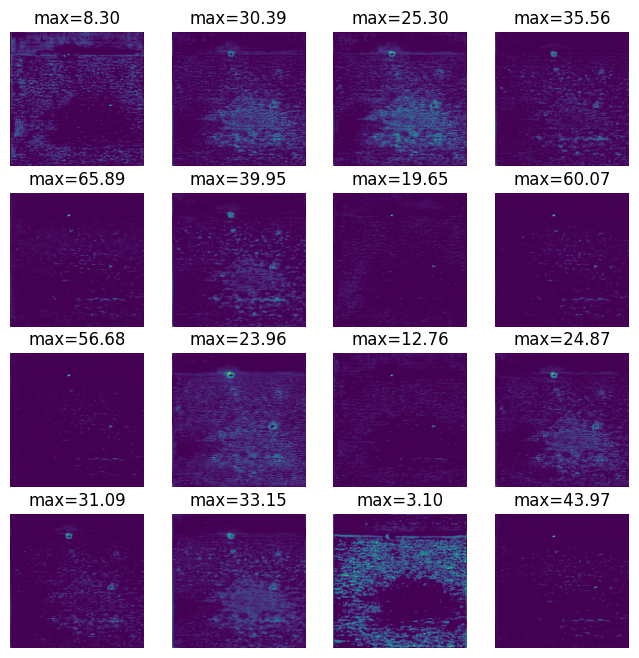

In [11]:
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.title(f'max={np.max(features_dna[0][k_batch, i]):.2f}')
    plt.imshow(features_dna[0][k_batch, i]/np.max(features_dna[0][k_batch]))
    plt.axis('off')

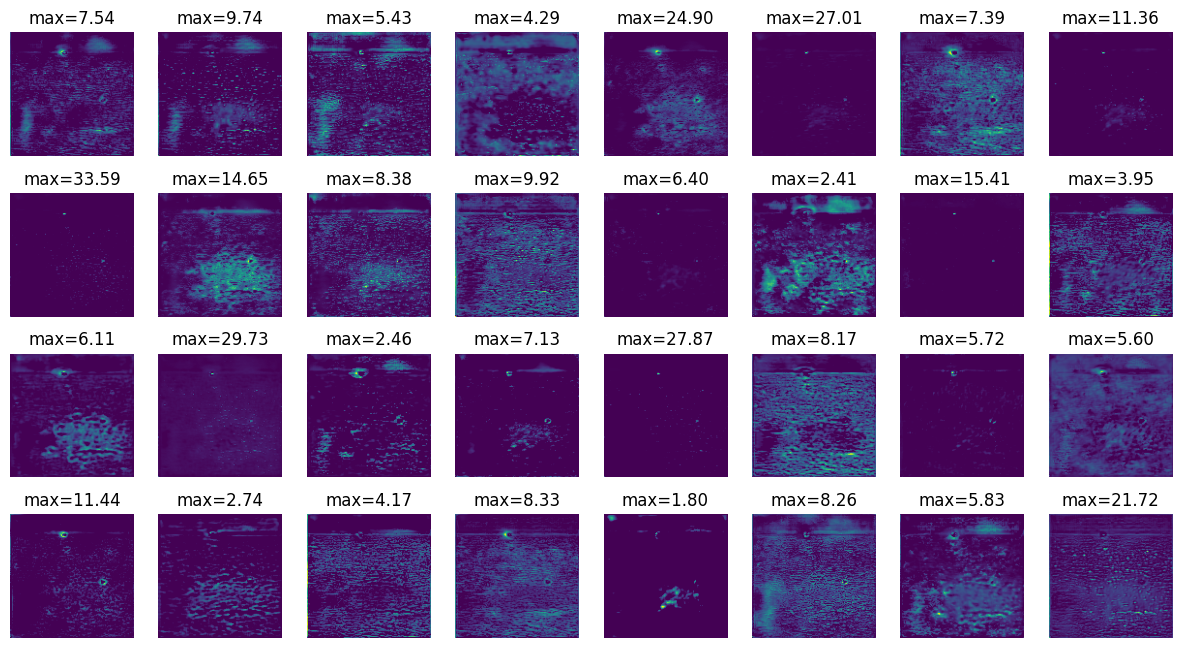

In [14]:
plt.figure(figsize=(15,8))
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.title(f'max={np.max(features_dna[1][k_batch, i]):.2f}')
    plt.imshow(features_dna[1][k_batch, i])
    plt.axis('off')

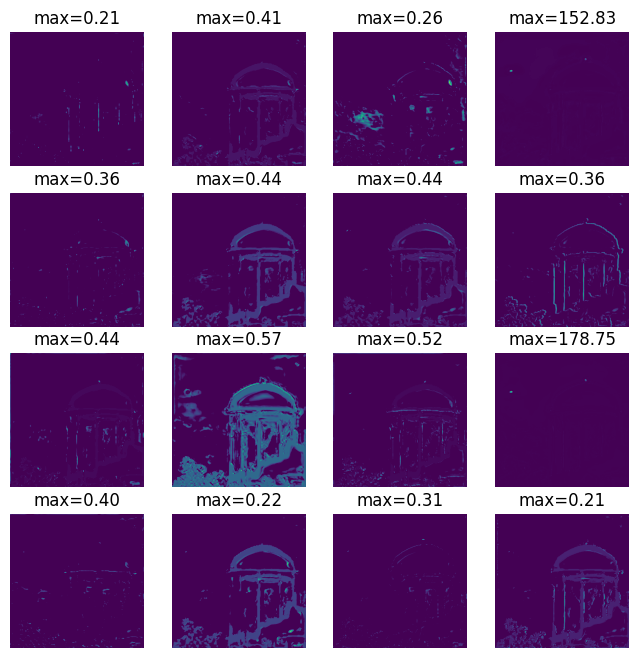

In [50]:
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.title(f'max={np.max(features[0][k_batch, i]):.2f}')
    plt.imshow(features[0][k_batch, i]/np.max(features[0][k_batch]))
    plt.axis('off')

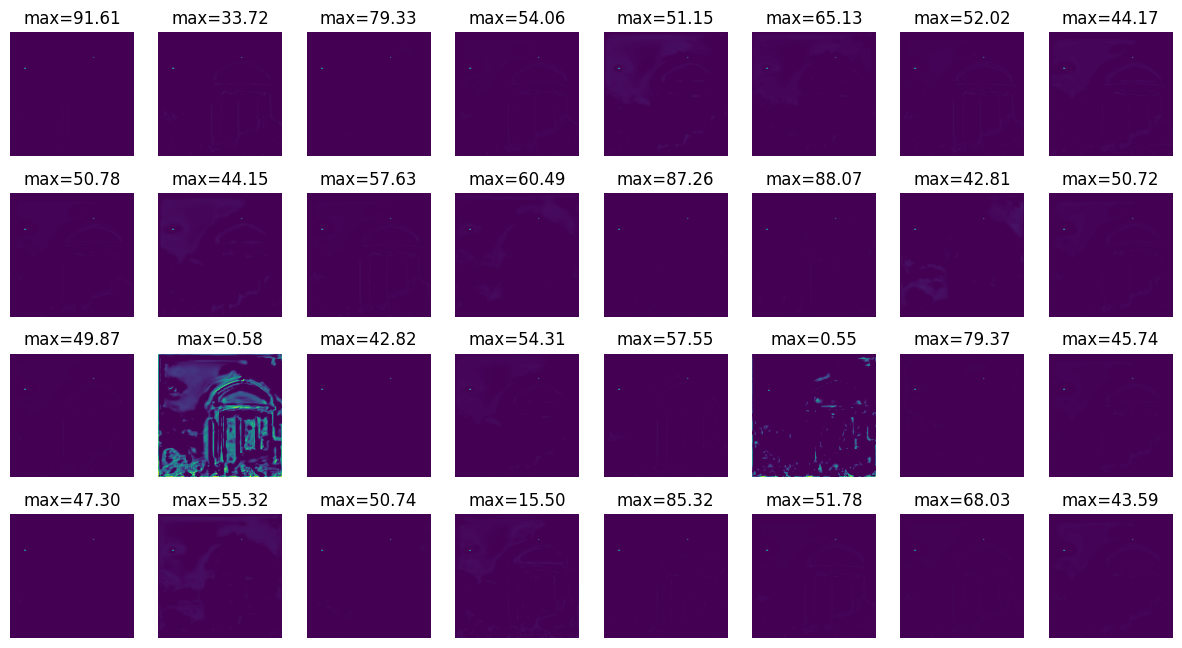

In [51]:
plt.figure(figsize=(15,8))
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.title(f'max={np.max(features[1][k_batch, i]):.2f}')
    plt.imshow(features[1][k_batch, i])
    plt.axis('off')

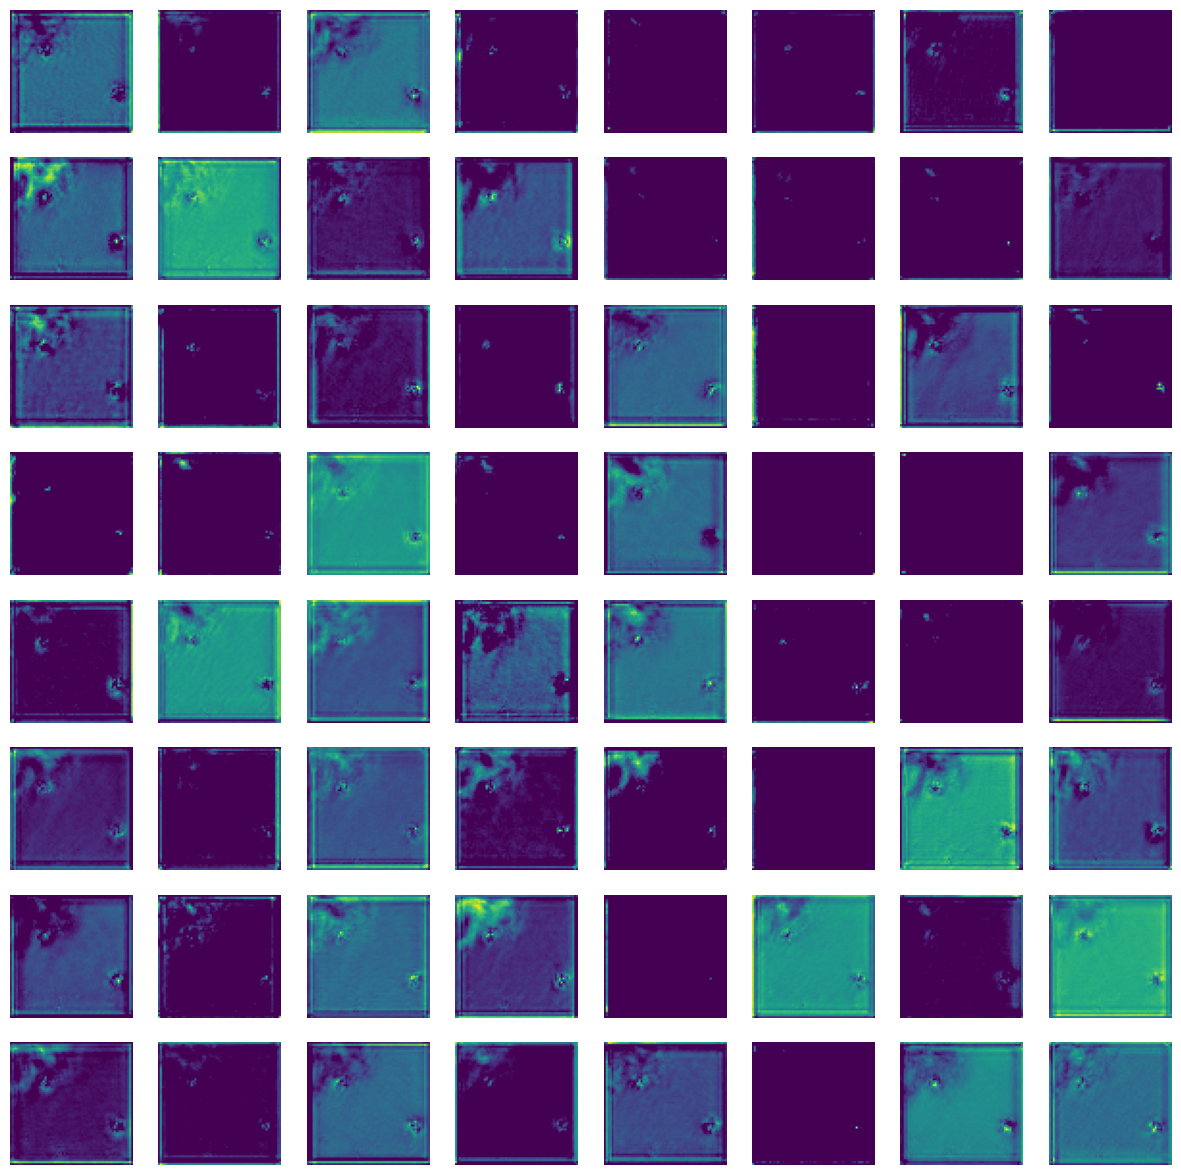

In [15]:
plt.figure(figsize=(15,15))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(features[2][k_batch, i])
    plt.axis('off')

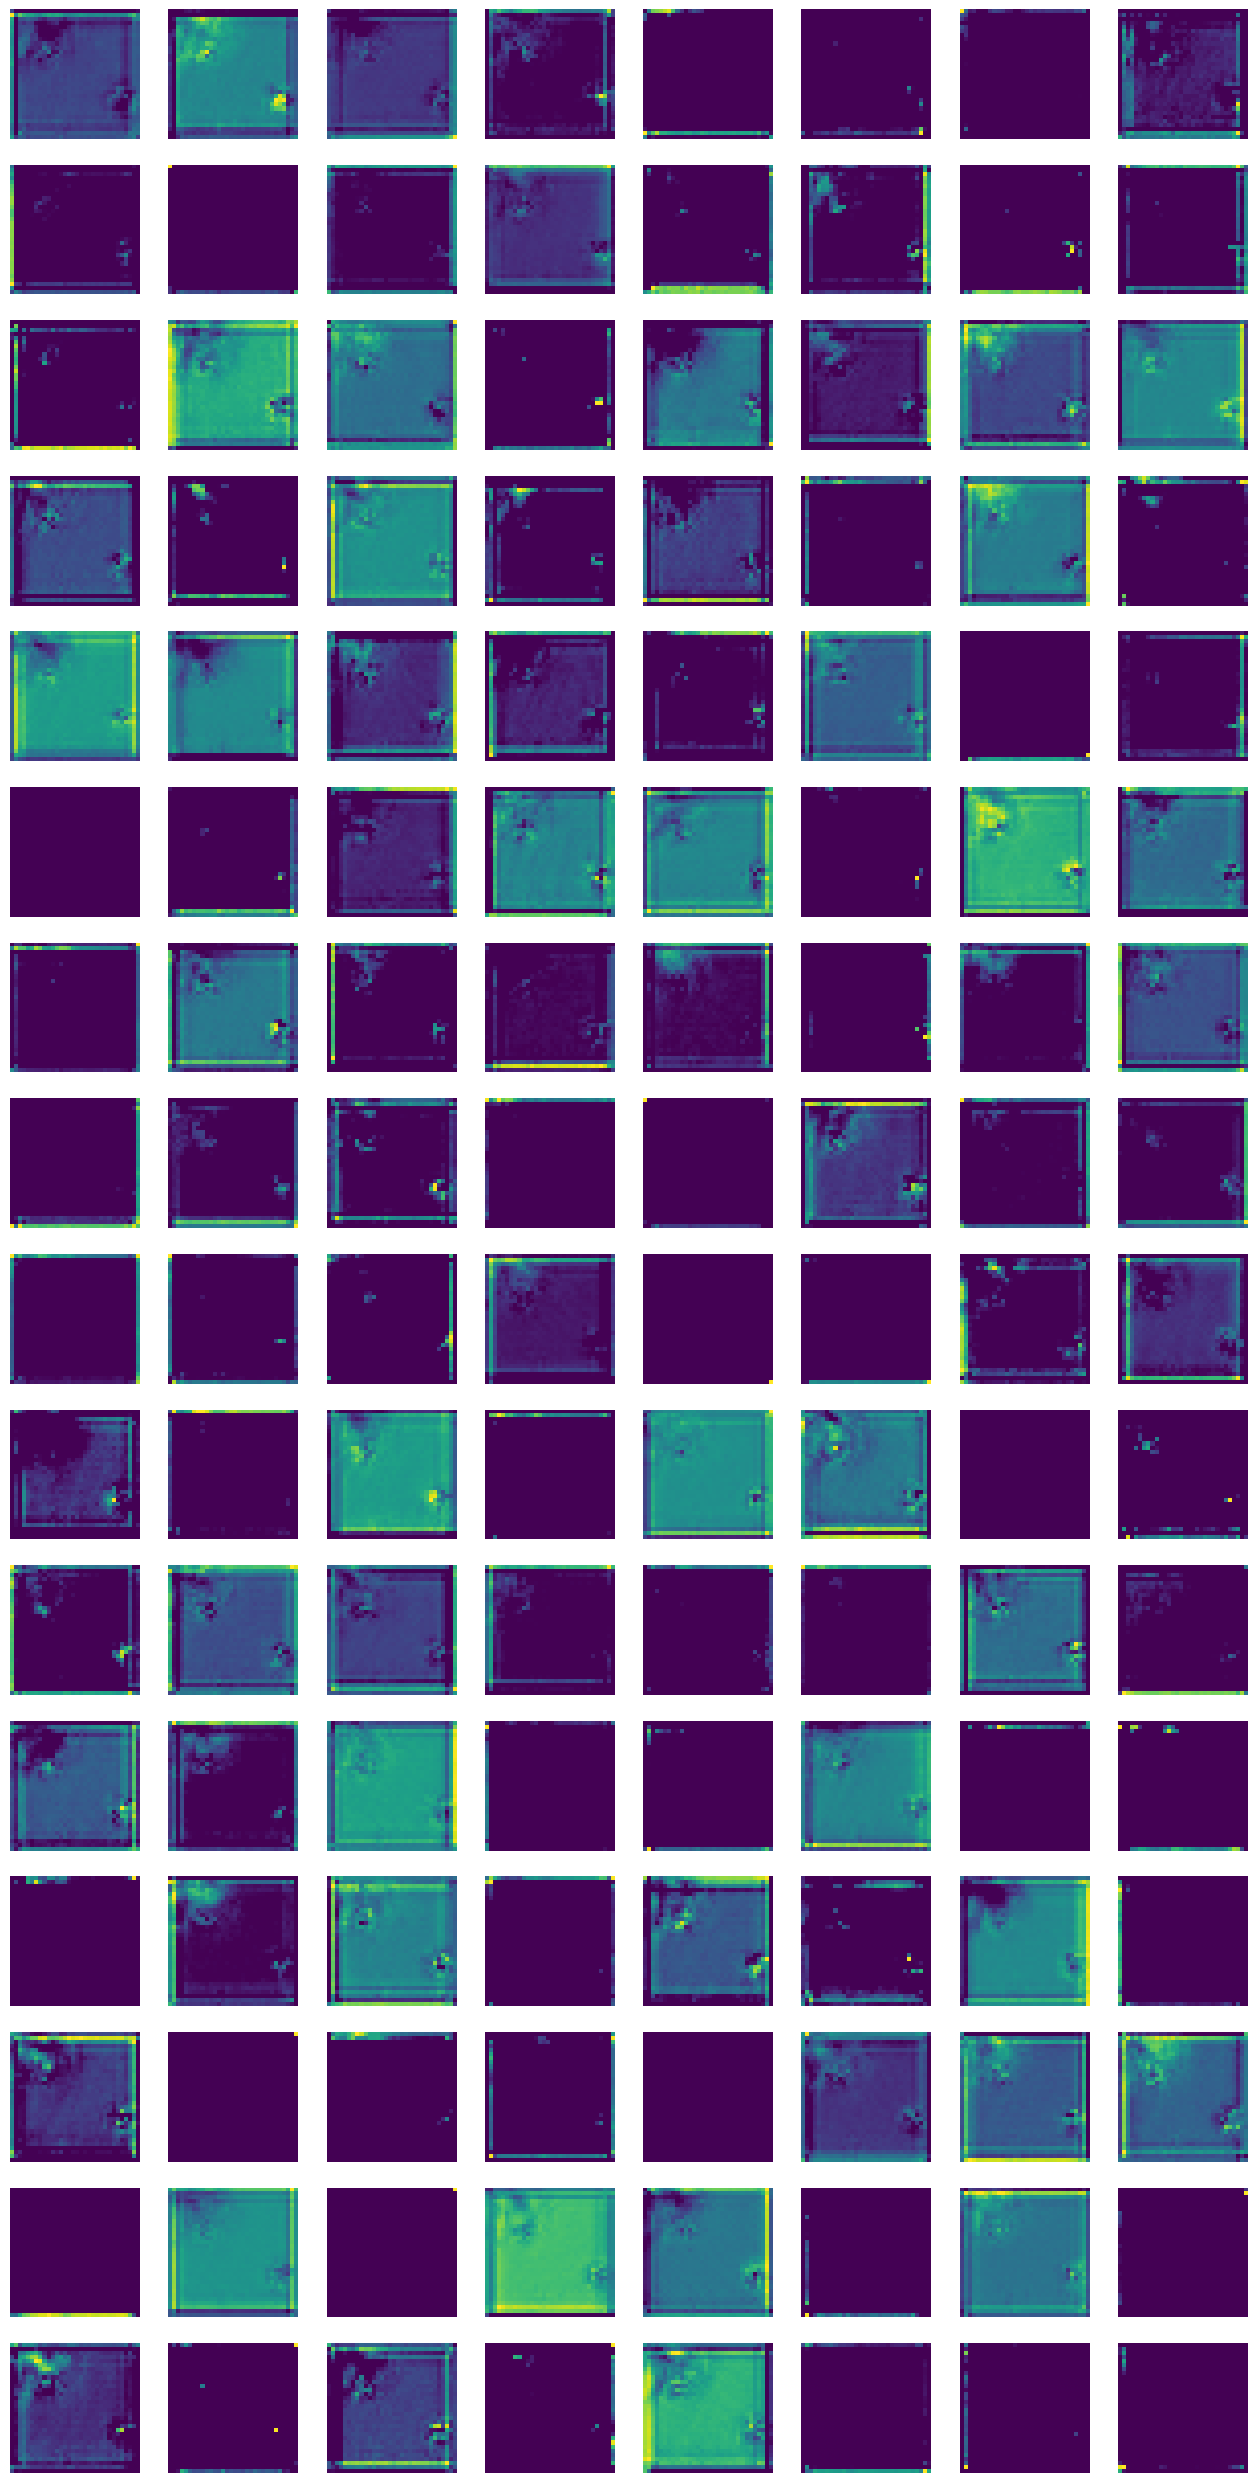

In [16]:
plt.figure(figsize=(16,32))
for i in range(128):
    plt.subplot(16,8,i+1)
    plt.imshow(features[3][k_batch, i])
    plt.axis('off')

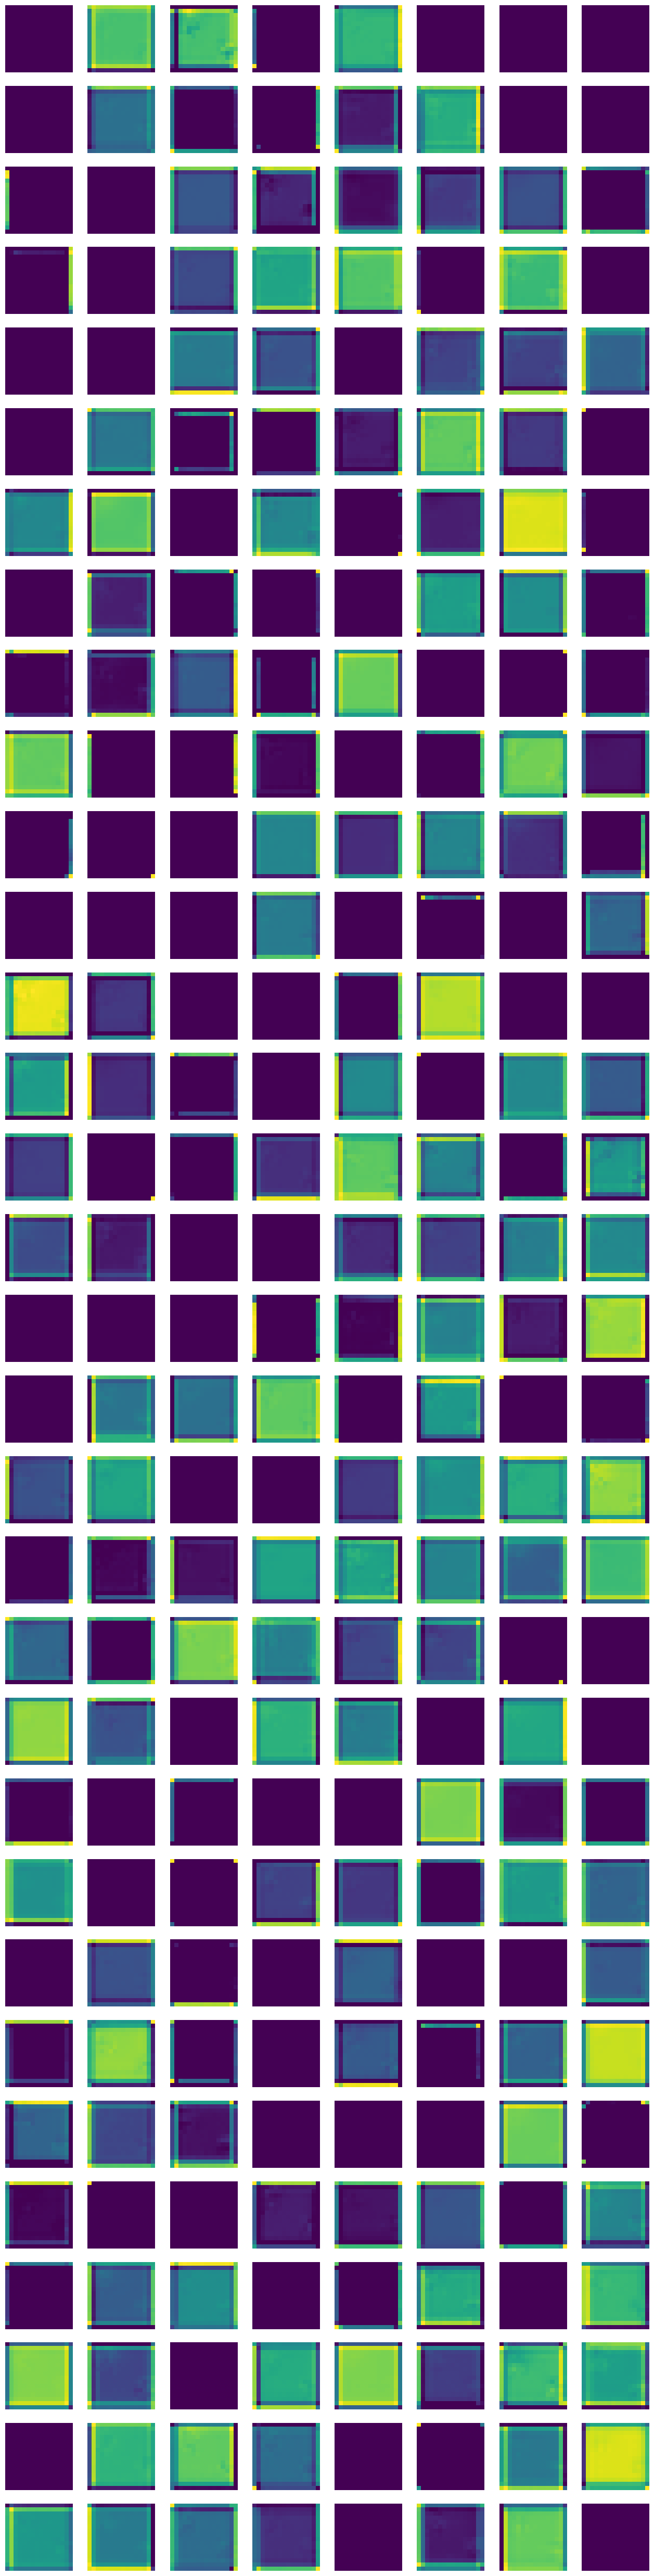

In [17]:
plt.figure(figsize=(16,64))
for i in range(256):
    plt.subplot(32,8,i+1)
    plt.imshow(features[4][k_batch, i])
    plt.axis('off')

### Loss SoftIoU

In [74]:
model.eval()
with torch.no_grad():
    (data, labels) = next(iter(test_data))
    data = data.cuda()
    labels = labels.cuda()
    pred = model(data)

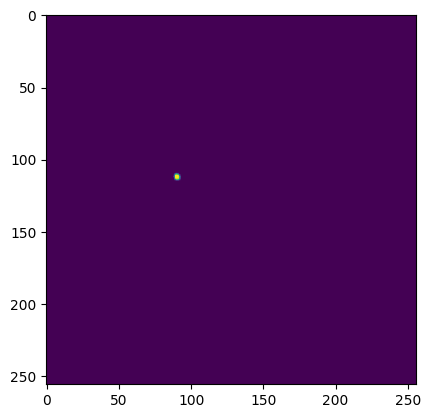

In [75]:
plt.imshow(pred.detach().cpu()[0,0])

In [76]:
loss = SoftIoULoss(pred, labels, sigmoid=False)
loss.item()

0.9961936473846436

In [82]:
smooth = 1
intersection = pred * labels
loss = (intersection.sum() + smooth) / (pred.sum() + labels.sum() -intersection.sum() + smooth)
loss = 1 - loss.mean()
loss

tensor(1., device='cuda:0')

In [73]:
labels.sum(), pred.sum(), intersection.sum()

(tensor(6., device='cuda:0'),
 tensor(7.0122, device='cuda:0'),
 tensor(3.8085, device='cuda:0'))

In [60]:
[i for i in pred.flatten() if i>0.86]

[tensor(0.9883, device='cuda:0'),
 tensor(0.9975, device='cuda:0'),
 tensor(0.9850, device='cuda:0'),
 tensor(0.9983, device='cuda:0'),
 tensor(0.9999, device='cuda:0'),
 tensor(0.9996, device='cuda:0'),
 tensor(0.9862, device='cuda:0'),
 tensor(0.9997, device='cuda:0'),
 tensor(0.9989, device='cuda:0')]

```bash
python train.py --base_size 256 --crop_size 256 --epochs 1000 --dataset NUAA-SIRST --split_method 60_40 --model DeepNFA --backbone resnet_18  --deep_supervision False --train_batch_size 8 --test_batch_size 8 --mode TXT --lr 0.03 --alpha 0.0005 --binarization_threshold 0.13
```

```bash
python test.py --base_size 256 --crop_size 256 --st_model pretrained --model_dir pretrained/pretrain_DNANet_model.tar --dataset NUAA-SIRST --split_method 60_40 --model DNANet --backbone resnet_18  --deep_supervision True --test_batch_size 1 --mode TXT 
```
```bash
python visulization.py --base_size 256 --crop_size 256 --st_model NUAA-SIRST_DeepNFA_23_03_2024_01_26_20_wDS --model_dir NUAA-SIRST_DeepNFA_23_03_2024_01_26_20_wDS/mIoU__DeepNFA_NUAA-SIRST_epoch.pth.tar --dataset NUAA-SIRST --split_method 60_40 --model DeepNFA --backbone resnet_18  --deep_supervision False --test_batch_size 1 --mode TXT --alpha 0.005 --binarization_threshold 0.86
```


In [3]:
import scipy.io as scio

scio.loadmat('dataset/NUAA-SIRST/value_result/NUAA-SIRST_DNANet_22_03_2024_01_46_45_wDS_PD_FA_255.mat')

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Fri Mar 22 16:31:42 2024',
 '__version__': '1.0',
 '__globals__': [],
 'number_record1': array([[1.48126256e-05, 5.97858987e-06, 5.97858987e-06, 5.35396107e-07,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
 'number_record2': array([[0.93518519, 0.84722222, 0.55092593, 0.23611111, 0.0462963 ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ]])}

In [4]:
scio.loadmat('dataset/NUAA-SIRST/value_result/pretrained_PD_FA_255')

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Fri Mar 22 17:38:48 2024',
 '__version__': '1.0',
 '__globals__': [],
 'number_record1': array([[2.24866365e-05, 1.27602739e-05, 2.32004980e-06, 8.03094161e-07,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
 'number_record2': array([[0.94907407, 0.89814815, 0.74074074, 0.43981481, 0.10185185,
         0.00925926, 0.00462963, 0.        , 0.        , 0.        ,
         0.        ]])}